In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score,StratifiedKFold
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
path = os.getenv("HOME")+"/aiffel/kaggle_kakr_housing/data"

In [2]:
train_data_path = join(path, 'train.csv')
sub_data_path = join(path, 'test.csv')

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [3]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [4]:
y = data['price']

del data['price']

In [5]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

In [6]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. 간단한 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<AxesSubplot:>

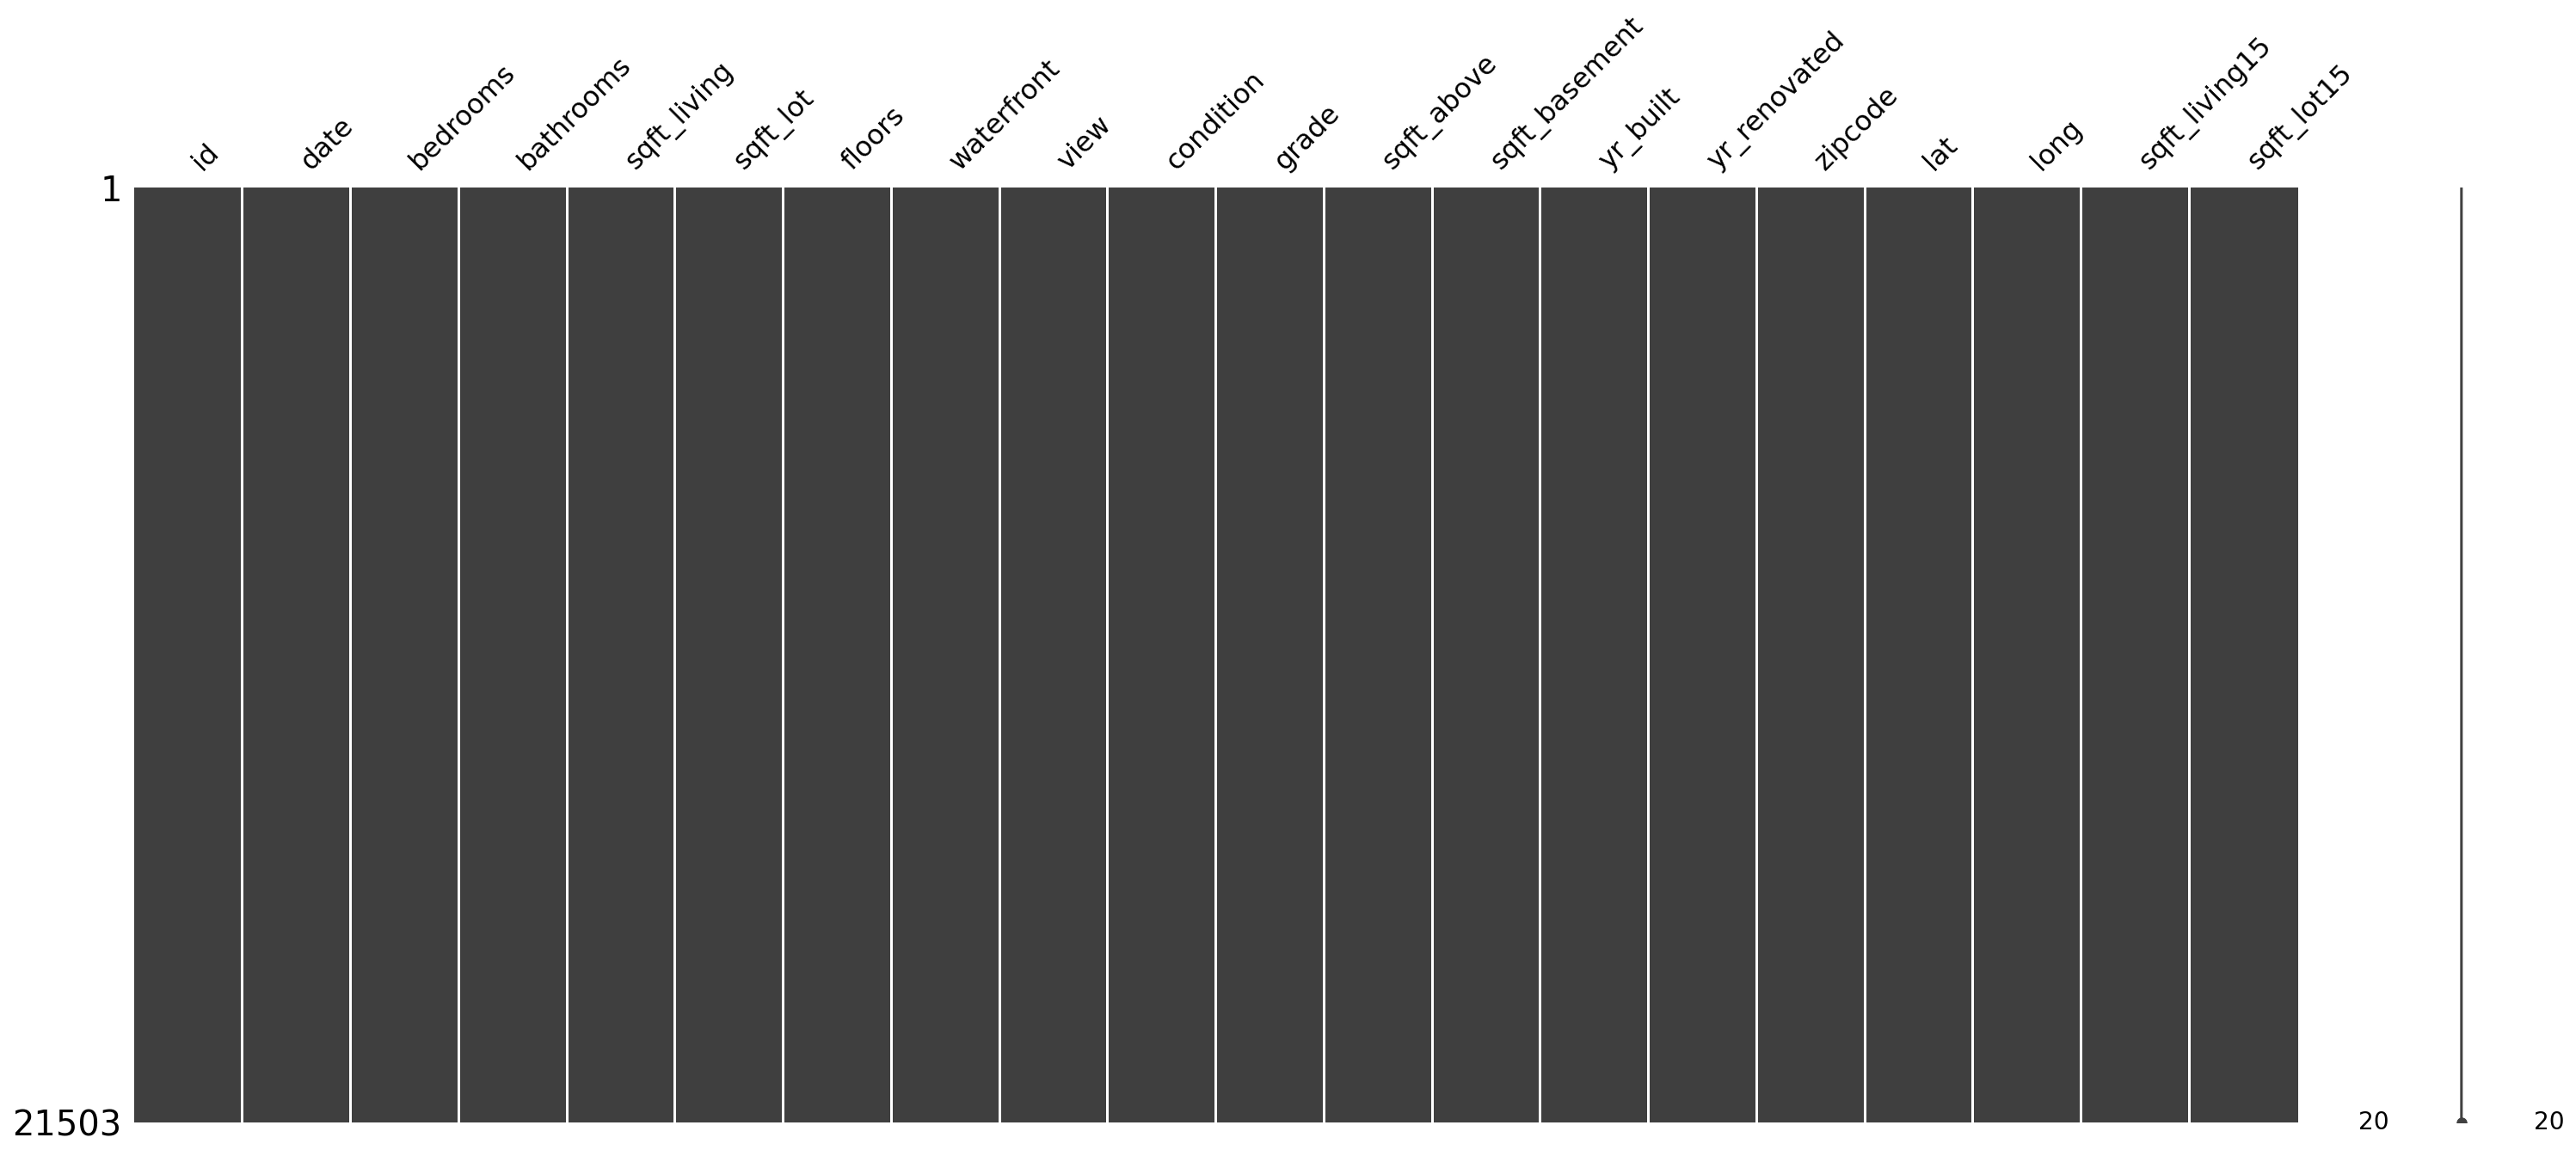

In [7]:
msno.matrix(data)

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

In [8]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [9]:
sub_id = data['id'][train_len:]
del data['id']
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(str)

### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

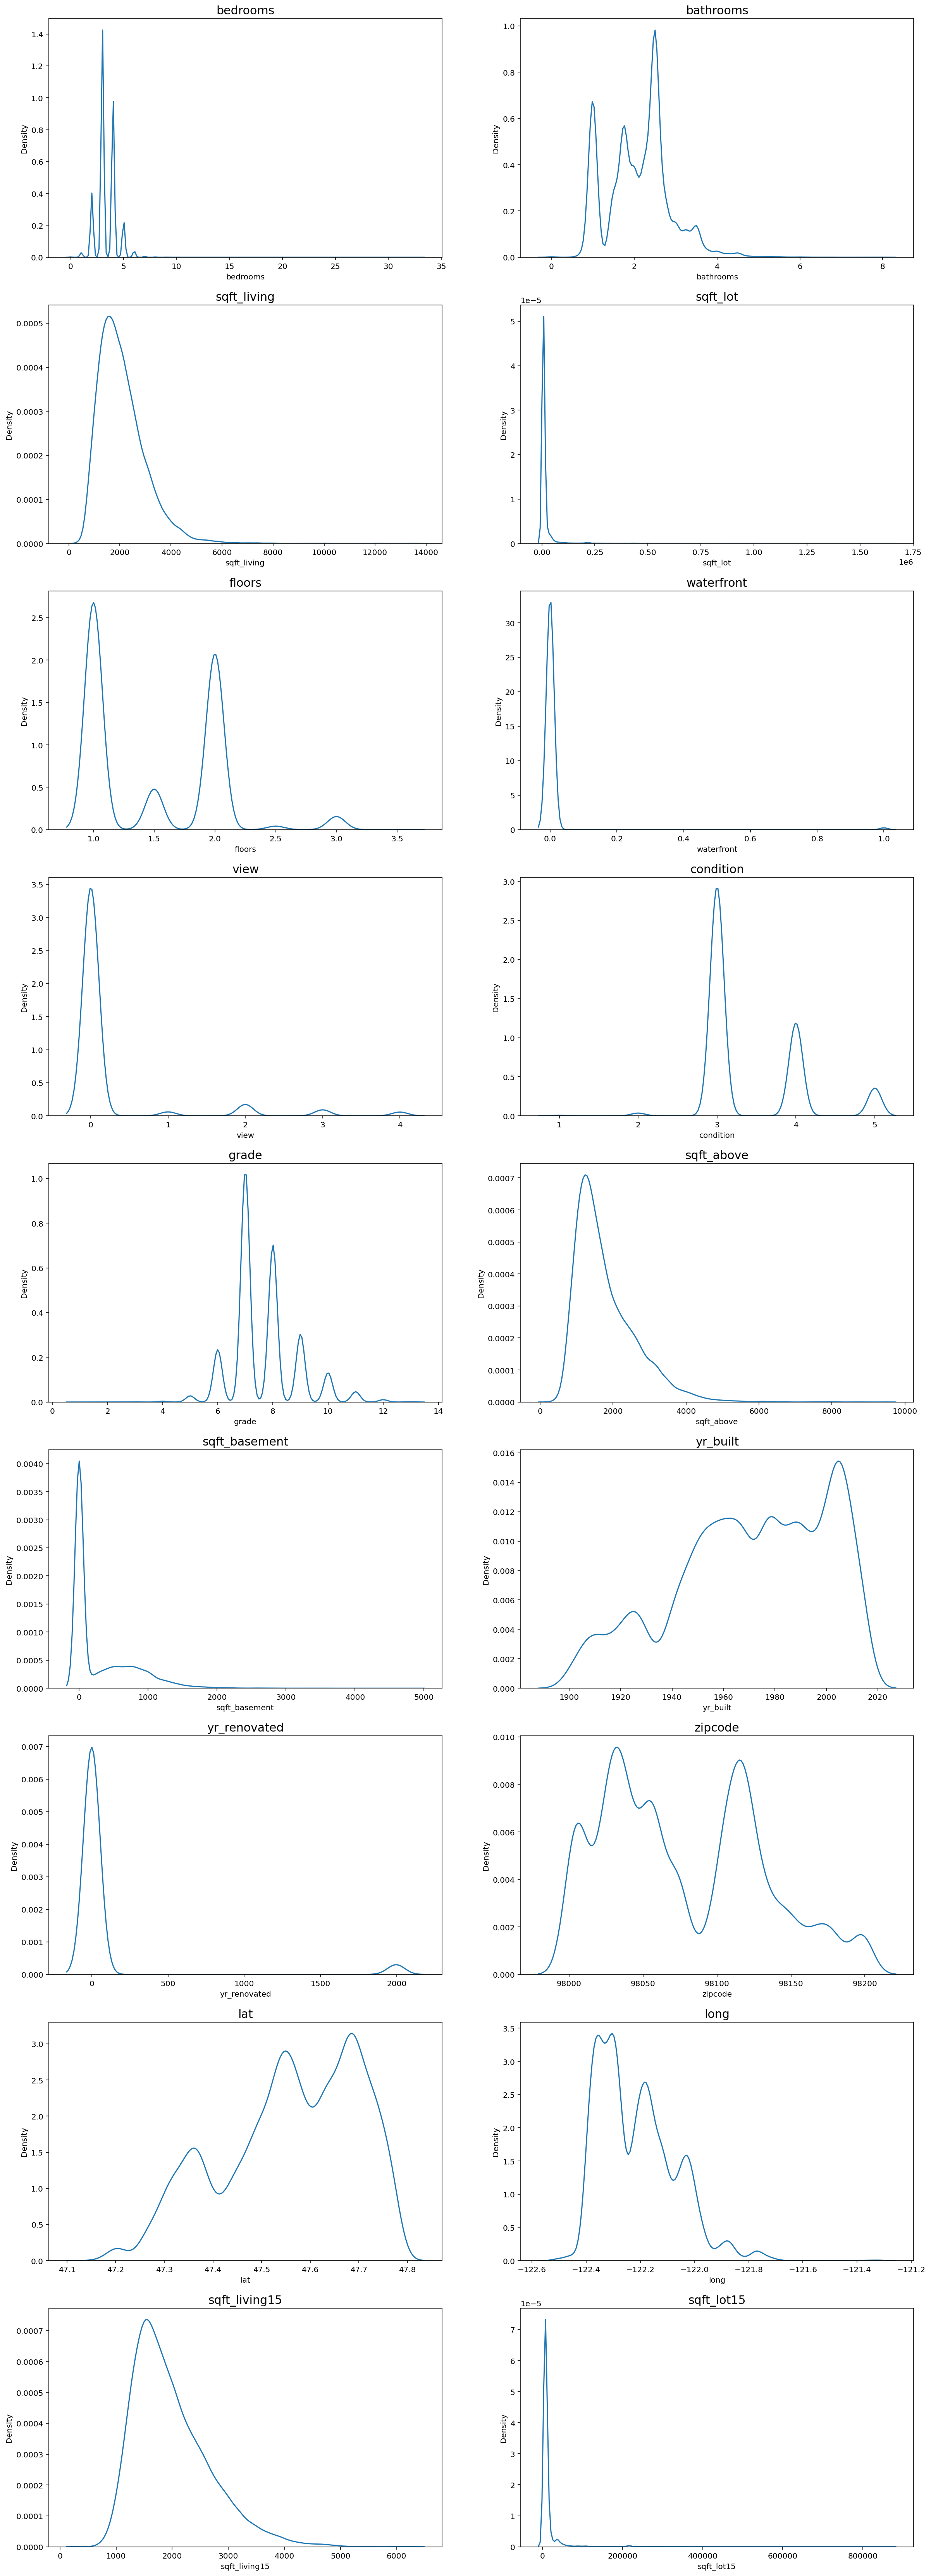

In [10]:
fig, ax = plt.subplots(9, 2, figsize=(20, 60))

# id 변수는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data = data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 19 :
            break

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [11]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

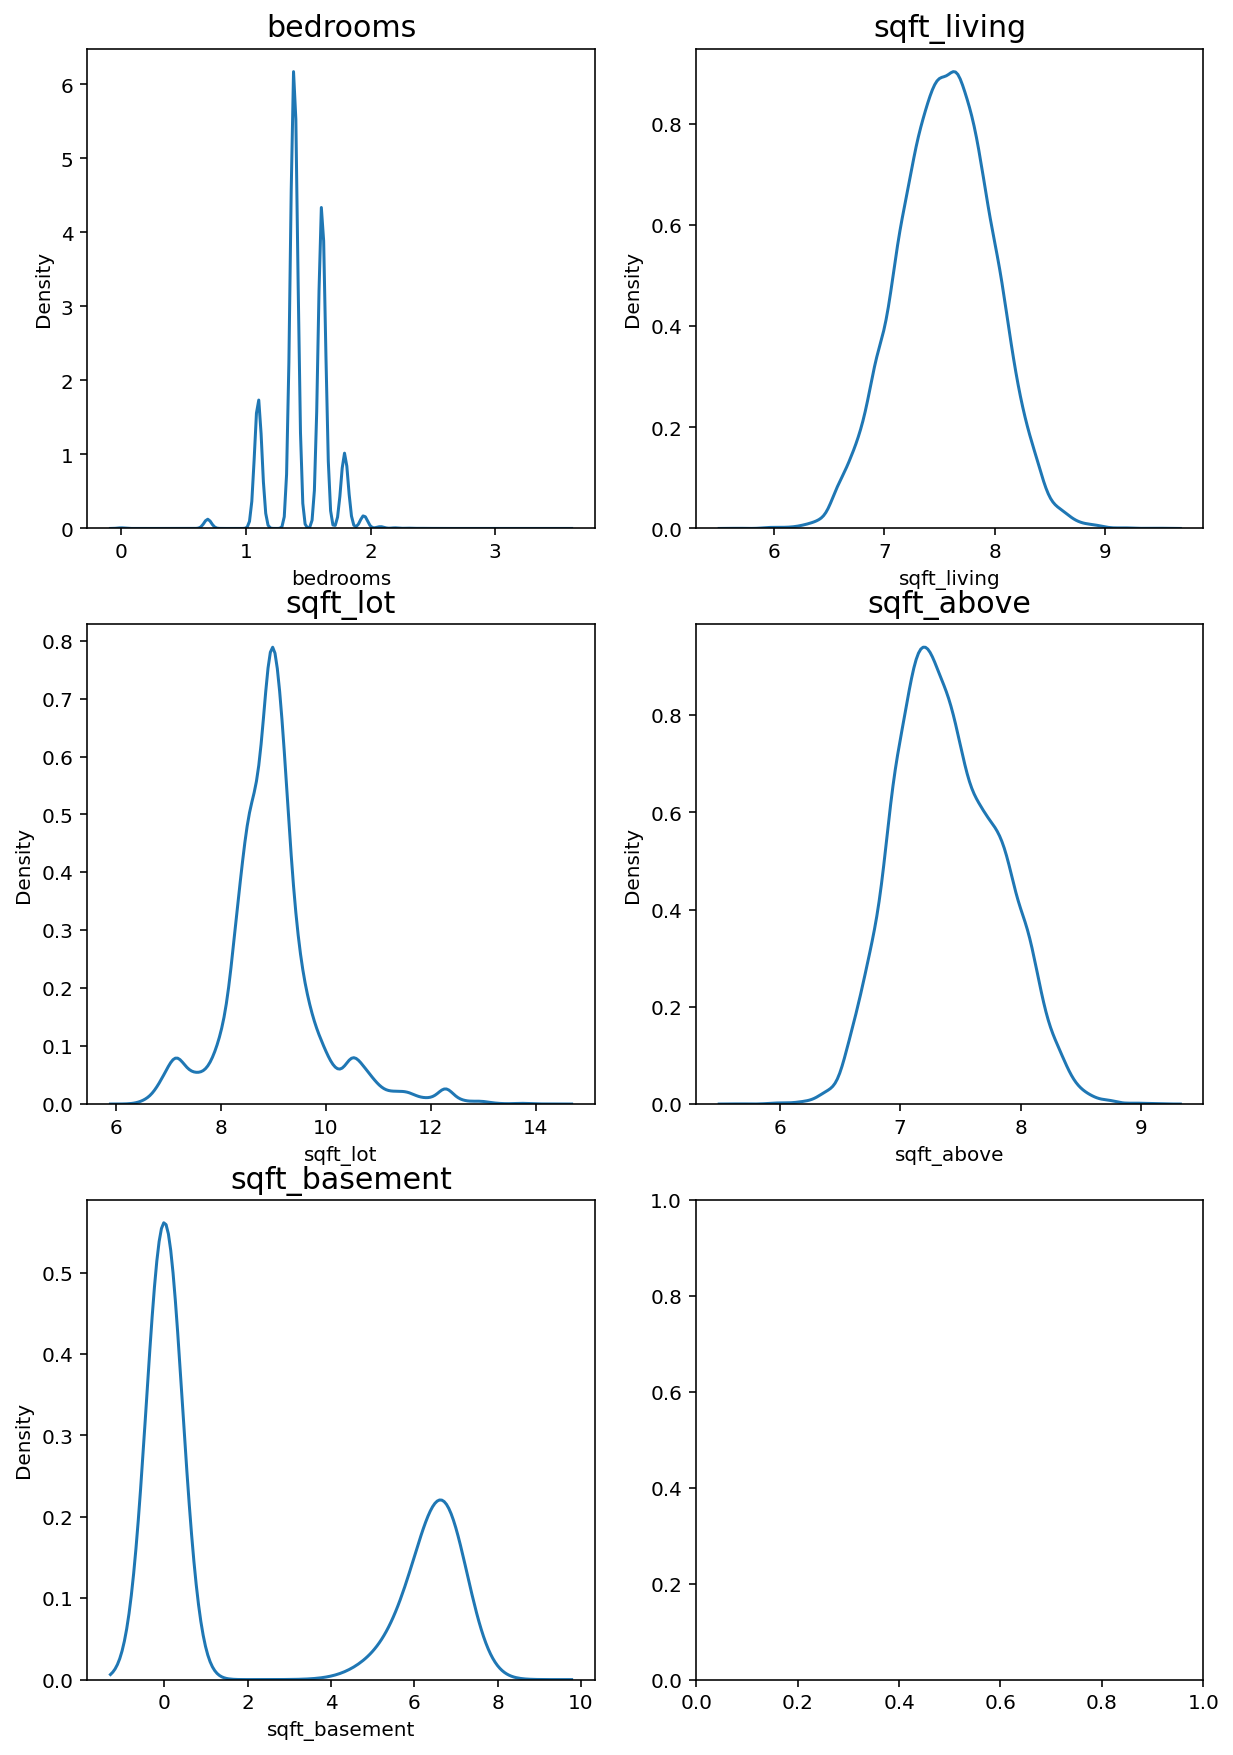

In [12]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data = data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1



어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

In [13]:
#다시 훈련 데이터와 테스트 데이터를 분리한다
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

## 3. 모델링
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

In [14]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

### Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

In [15]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019,shuffle=True).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), 
                                             kf=kfold))

In [16]:
get_cv_score(models)

Model GradientBoosting CV score : 0.8597
Model XGBoost CV score : 0.8861
Model LightGBM CV score : 0.8819


### Make Submission

회귀 모델의 경우에는 cross_val_score 함수가 R<sup>2</sup>를 반환합니다.<br>
R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타냅니다. 3개 트리 모델이 상당히 훈련 데이터에 대해 괜찮은 성능을 보여주고 있습니다.<br> 훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.

In [17]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [18]:
y_pred = AveragingBlending(models, x, y, sub)

In [19]:
sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})

In [20]:
sub.to_csv('submission.csv', index=False)

### 주도적으로 데이터를 다뤄봅시다

In [21]:
dir_path = os.getenv("HOME")+"/aiffel/kaggle_kakr_housing/data"
train_data_path = join(dir_path,'train.csv')
test_data_path = join(dir_path,'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [22]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [23]:
del train['id']
train['date'] = train['date'].apply(lambda i : i[:6]).astype(int)
train.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [24]:
y = train['price']
del train['price']

In [25]:
del test['id']
test['date'] = test['date'].apply(lambda i : i[:6]).astype(int)
test.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


<AxesSubplot:xlabel='price', ylabel='Density'>

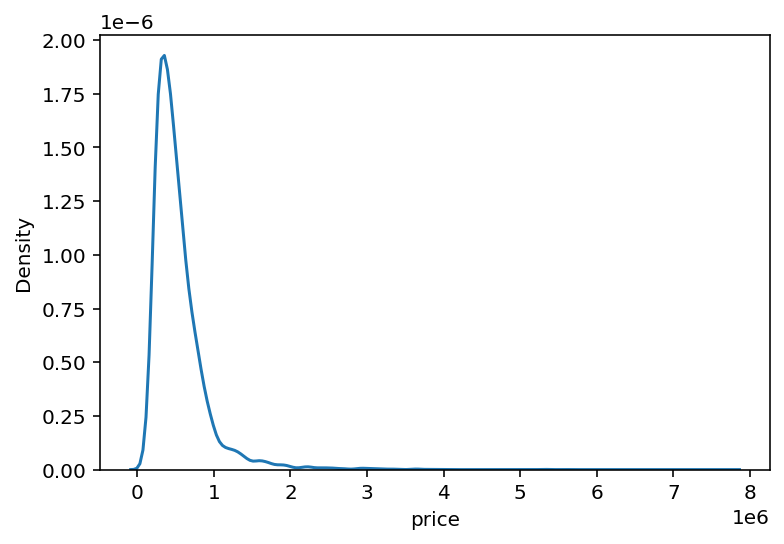

In [26]:
sns.kdeplot(y)

### price의 분포가 왼쪽으로 치우쳐있는데..
한쪽으로 치우친 분포는 모델이 예측하는데 좋지않으므로 log 변환를 통해 골고루 분포하도록 하고 모델이 값을 예측했을 때 지수변환으로 되돌리도록 합니다.

<AxesSubplot:xlabel='price', ylabel='Density'>

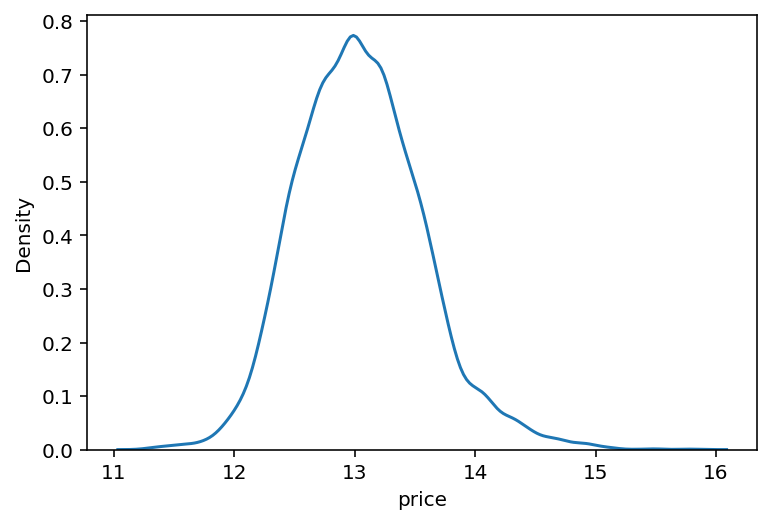

In [27]:
y = np.log1p(y)
y
sns.kdeplot(y)

### 전처리가 완료된 데이터입니다.
아래와 같이 모두 정수 혹은 실수형으로 모델 학습에 활용할 수 있게 되었습니다.

In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [30]:
#mean squared error를 계산하기 위한 함수
def rmse(y_test,y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_text),np.expm(y_pred)))

In [31]:
#모델 import
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [32]:
random_state=2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [33]:
#모델별 mse를 구하는 함수
def get_scores(models, train, y):
    df = {}
    for m in models:
        model_name = m.__class__.__name__
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        m.fit(X_train,y_train)
        y_pred = m.predict(X_test)
        df[model_name] = rmse(y_test,y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    return score_df

## 그리드 탐색이란?
그리드 탐색이란 사람이 먼저 탐색할 하이퍼 파라미터의 값들을 정해두고, 그 값들로 만들어질 수 있는 모든 조합을 탐색합니다.

반면에 랜덤탐색은 사람이 탐색할 하이퍼 파라미터의 공간만 정하고 그 안에서 랜덤으로 조합을 선택해 탐색하는 방법입니다.

### GridSearchCv에 입력되는 인자
* param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력됩니다.)
* scoring : 모델의 성능을 평가할 지표
* cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 갯수
* verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양
* n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수

In [34]:
from sklearn.model_selection import GridSearchCV

In [35]:
param_grid = {
    'n_estimators': [50,80,100],
    'max_depth' : [1,10],
}
model = LGBMRegressor(random_state = random_state)

In [36]:
def my_GridSearch(model,train,y,param_grid,verbose = 2,n_jobs = 5):
    
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)  
    
    grid_model.fit(train, y)

    
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    
    results = pd.DataFrame(params)
    results['score'] = score
    
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [37]:
#모델을 학습시키고 저장
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    #로그화되었던 price를 지수화한다
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

### 그리드 서치를 이용해 가장 최적의 파라미터를 찾습니다.

In [38]:
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,max_depth,n_estimators,score,RMSLE
5,10,100,-0.027027,0.164399
4,10,80,-0.027472,0.165746
3,10,50,-0.029177,0.170814
2,1,100,-0.055020,0.234564
1,1,80,-0.060010,0.244969
0,1,50,-0.073394,0.270914


In [39]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)

In [40]:
save_submission(model,train,y,test,'lgbm',rmsle='0.0168')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.0168.csv saved!


## 예측 정확도를 올려봅시다.

In [41]:
gboost = GradientBoostingRegressor(random_state=2022)
xgboost = xgb.XGBRegressor(random_state=2022)
lightgbm = lgb.LGBMRegressor(random_state=2022)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

In [42]:
#모델별 그리드 탐색
#10,100
#my_GridSearch(models[0]['model'], train, y, param_grid, verbose=2, n_jobs=5)
#my_GridSearch(models[1]['model'], train, y, param_grid, verbose=2, n_jobs=5)
my_GridSearch(models[2]['model'], train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,max_depth,n_estimators,score,RMSLE
5,10,100,-0.027027,0.164399
4,10,80,-0.027472,0.165746
3,10,50,-0.029177,0.170814
2,1,100,-0.055020,0.234564
1,1,80,-0.060010,0.244969
0,1,50,-0.073394,0.270914


In [43]:
#블렌딩 기법을 위해 함수를 새롭게 정의
gboost = GradientBoostingRegressor(max_depth=10, n_estimators=100,random_state=2022)
xgboost = xgb.XGBRegressor(max_depth=10, n_estimators=100,random_state=2022)
lightgbm = lgb.LGBMRegressor(max_depth=10, n_estimators=100,random_state=2022)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

def modelfitting(models,train,y,test):
    for m in models : 
        m['model'].fit(train, y)
    
    predictions = np.column_stack([
        np.expm1(m['model'].predict(test)) for m in models
    ])
    return np.mean(predictions, axis=1)
    
def save_submission_2(models, train, y, test, model_name, rmsle=None):
    prediction = modelfitting(models,train,y,test)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [44]:
#113000..ㅠㅠ
save_submission_2(models,train,y,test,'lgbm',rmsle='0.0168')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.0168.csv saved!


### 스태킹 앙상블

In [45]:
from sklearn.linear_model import LogisticRegression

In [46]:
#개별 모델
gboost = GradientBoostingRegressor(max_depth=10, n_estimators=100,random_state=2022)
xgboost = xgb.XGBRegressor(max_depth=10, n_estimators=100,random_state=2022)
lightgbm = lgb.LGBMRegressor(max_depth=10, n_estimators=100,random_state=2022)

#최종 모델
lr = LogisticRegression()

def get_stacking(model,x_train,y_train,x_test,n_folds=5):
    kfold = KFold(n_splits=n_folds)
    train_fold_predict = np.zeros((x_train.shape[0],1))
    
    test_predict = np.zeros((x_test.shape[0],n_folds))
    X_train = x_train.to_numpy()
    X_test = x_test.to_numpy()
    for cnt,(train_idx,valid_idx) in enumerate(kfold.split(X_train)):
        X_train_ = X_train[train_idx]
        y_train_ = y_train[train_idx]
        X_val_ = X_train[valid_idx]
        
        model.fit(X_train_,y_train_)
        #검증 데이터 예측 후 저장
        train_fold_predict[valid_idx,:] = model.predict(X_val_).reshape(-1,1)
        
        test_predict[:,cnt] = model.predict(X_test)
        
    test_predict_mean = np.mean(test_predict,axis=1).reshape(-1,1)
    
    return train_fold_predict, test_predict_mean

def save_submission_3(prediction, model_name, rmsle=None):
    
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))
    

In [47]:
gb_train,gb_test = get_stacking(gboost,train,y,test)
xgb_train,xgb_test = get_stacking(xgboost,train,y,test)
lgb_train,lgb_test = get_stacking(lightgbm,train,y,test)

#스택
new_train = np.concatenate((gb_train,xgb_train,lgb_train),axis=1)
new_test = np.concatenate((gb_test,xgb_test,lgb_test),axis=1)

In [49]:
print(new_train.shape,y.shape)
print(train.shape,y.shape)
y_ = np.expm1(y)
y_ = y_.astype('int')
lr.fit(new_train,y_)
stack_pred = lr.predict(new_test)

save_submission_3(stack_pred,'stack')

(15035, 3) (15035,)
(15035, 19) (15035,)
/aiffel/aiffel/kaggle_kakr_housing/data/submission_stack_RMSLE_None.csv saved!


## 회고합시다.
* 기준치에 맞추고싶긴 했지만 블렌딩 기법으론 113000점이 한계인것 같습니다.
* 스태킹 앙상블 기법을 사용해보고자 했지만 어디가 잘못됬던건지 점수가 매우 떨어졌습니다.  아무래도 이번 노트북에 쌓인 코드가 너무 많아 저부터가 많이 혼동이 온 것 같습니다.  해당 내용은 추후 다시 깔끔하게 정리해봐야겠습니다.